# SETUP

## Check environment

In [1]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: True


In [2]:
!pip install --upgrade pip tensorflow keras scikit-learn &> pip.log
!pip install openpyxl pydot >> pip.log
!apt-get install graphviz -y &> apt.log
#pip isntall 'tensorflow[and-cuda]' >> pip.log

if not COLAB:
    !pip install jupyterlab-vim jupyterlab-indent-guides >> pip.log

## Libraries

In [3]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Custom libraries written by myself
from src.drawing.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM

# Configuration reader
from src.config_reader.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [4]:
confReader = ConfigurationReader("/content/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/content/air_quality_index_project/dataset/MatchingData2022.xlsx"
        },
        "aod2021": {
            "file_dir": "/content/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31"
        },
        "mpair": {
            "file_dir": "/content/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31"
        }
    },
    "workspace": {
        "model_info_dir": "/content/model_info",
        "model_checkpoints_dir": "/content/model_checkpoints",
        "data_by_location_dir": "/content/data_by_location",
        "data_by_station_dir": "/content/data_by_station",
        "data_statistic_dir": "/content/data_statistic"
    },
    "prediction": {
        "n_past": 7,
        "n_future": 1,
        "epochs": 20,
        "batch_size": 128
    },
    "r

# AOD DATA

## Load 2022 dataset

In [5]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


,time,ID,pm25,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,Name
0,2022-01-01,S4,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
1,2022-01-01,S5,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,...,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568,Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3
2,2022-01-01,S6,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
3,2022-01-01,S7,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
4,2022-01-02,S4,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,S6,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
994,2022-12-30,S7,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
995,2022-12-31,S4,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
996,2022-12-31,S6,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"


In [6]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Sort data by "station" then "time"
#df_aod_raw_2022.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Print
df_aod_raw_2022

,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,aod,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,101227.000000,0.338000,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
2022-01-01,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2022-01-01,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,101204.875000,0.128542,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-01-01,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-01-02,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,101201.015625,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-12-30,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-12-31,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,101322.437500,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486


## Load 2021 dataset

In [7]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


,time,ID,pm25,Lat,Lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,1/1/2018,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1,1/1/2018,202,29.615625,10.762638,106.682027,32.099998,25.100436,71.060891,457.243423,2.344162,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,NaN
2,1/2/2018,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.110117
3,1/2/2018,202,36.244792,10.762638,106.682027,44.619999,24.663358,73.870799,338.530190,1.885305,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,1.277641
4,1/3/2018,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.439045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,12/31/2021,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2887,12/31/2021,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2888,12/31/2021,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610
2889,12/31/2021,214,20.549839,10.815570,106.717500,21.040001,24.367620,67.038559,168.648315,2.101351,...,2327.256348,2.546965,1876.639945,841524.8595,296.311570,3753.279890,91461.50468,61731.577130,1818.661486,0.524898


In [8]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns},
                  inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Sort data by "station" then "time"
#df_aod_raw_2021.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Remove stations 201 and 202
#condition = (df_aod_raw_2021["station"] == 201) | (df_aod_raw_2021["station"] == 202)
#df_aod_raw_2021 = df_aod_raw_2021.loc[~condition]

# Print
df_aod_raw_2021

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2018-01-01,202,29.615625,10.762638,106.682027,32.099998,25.100436,71.060891,457.243423,2.344162,64615.49219,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,NaN
2018-01-02,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.110117
2018-01-02,202,36.244792,10.762638,106.682027,44.619999,24.663358,73.870799,338.530190,1.885305,64615.49219,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,1.277641
2018-01-03,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.439045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,14886.63672,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2021-12-31,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,35151.59375,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2021-12-31,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,27580.67383,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610


## Merge dataset

In [9]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Print
df_aod_raw

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2018-01-02,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,1.110117
2018-01-03,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,1.439045
2018-01-04,201,51.260870,10.783057,106.700606,40.259998,26.514926,82.982475,462.504210,1.588872,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.588595
2018-01-05,201,18.909091,10.783057,106.700606,21.690001,25.483535,93.046504,324.735356,2.505876,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [10]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [26]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [27]:
df_aod_raw.isnull().sum()

,0
station,0
pm25,0
lat,0
lon,0
pm25_3km,0
tmp,0
rh,0
hpbl,0
wspd,0
pop,0


## Preprocessing

### Define label, static features and dynamic features

In [ ]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['tmp', 'hpbl', 'aod', 'wspd', 'rh', 'pm25_3km']
aod_all_stations = [np.int64(201), np.int64(202), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216)]


### Fill "aod" column

In [ ]:
all_stations_df = []

for station in aod_all_stations:
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())

    # Store file for debugging after filling missing values
    df_aod_current_station.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.702394
2018-01-02,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,1.110117
2018-01-03,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,1.439045
2018-01-04,201,51.260870,10.783057,106.700606,40.259998,26.514926,82.982475,462.504210,1.588872,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.588595
2018-01-05,201,18.909091,10.783057,106.700606,21.690001,25.483535,93.046504,324.735356,2.505876,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.702394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [29]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time

In [30]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3889, freq=None)

### Split into features and labels
* Label: pm25_3km
* Features: other columns
    * Dynamic features
    * Static features

In [31]:
X_aod = df_aod.loc[:, aod_stat_feats + aod_dyn_feats]
y_aod = df_aod.loc[:, aod_label]

In [32]:
X_aod

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,tmp,hpbl,aod,wspd,rh,pm25_3km
time,,,,,,,,,,,,,,,,,,,,
2018-01-01,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,25.204139,455.131335,0.702394,2.352895,70.056728,34.919998
2018-01-02,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,24.726431,339.083720,1.110117,1.903761,73.425826,51.830002
2018-01-03,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,26.095087,367.190738,1.439045,1.293329,77.793432,38.240002
2018-01-04,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,26.514926,462.504210,0.588595,1.588872,82.982475,40.259998
2018-01-05,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,25.483535,324.735356,0.702394,2.505876,93.046504,21.690001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,24.136936,457.798645,0.535331,2.002987,73.973083,34.439411
2022-12-28,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,25.844296,644.974548,0.535331,2.298220,65.530487,29.838476
2022-12-29,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,25.841156,825.517395,0.191691,2.823764,67.093735,28.450829


In [19]:
y_aod

,pm25
time,
2018-01-01,31.391304
2018-01-02,37.458333
2018-01-03,68.083333
2018-01-04,51.260870
2018-01-05,18.909091
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


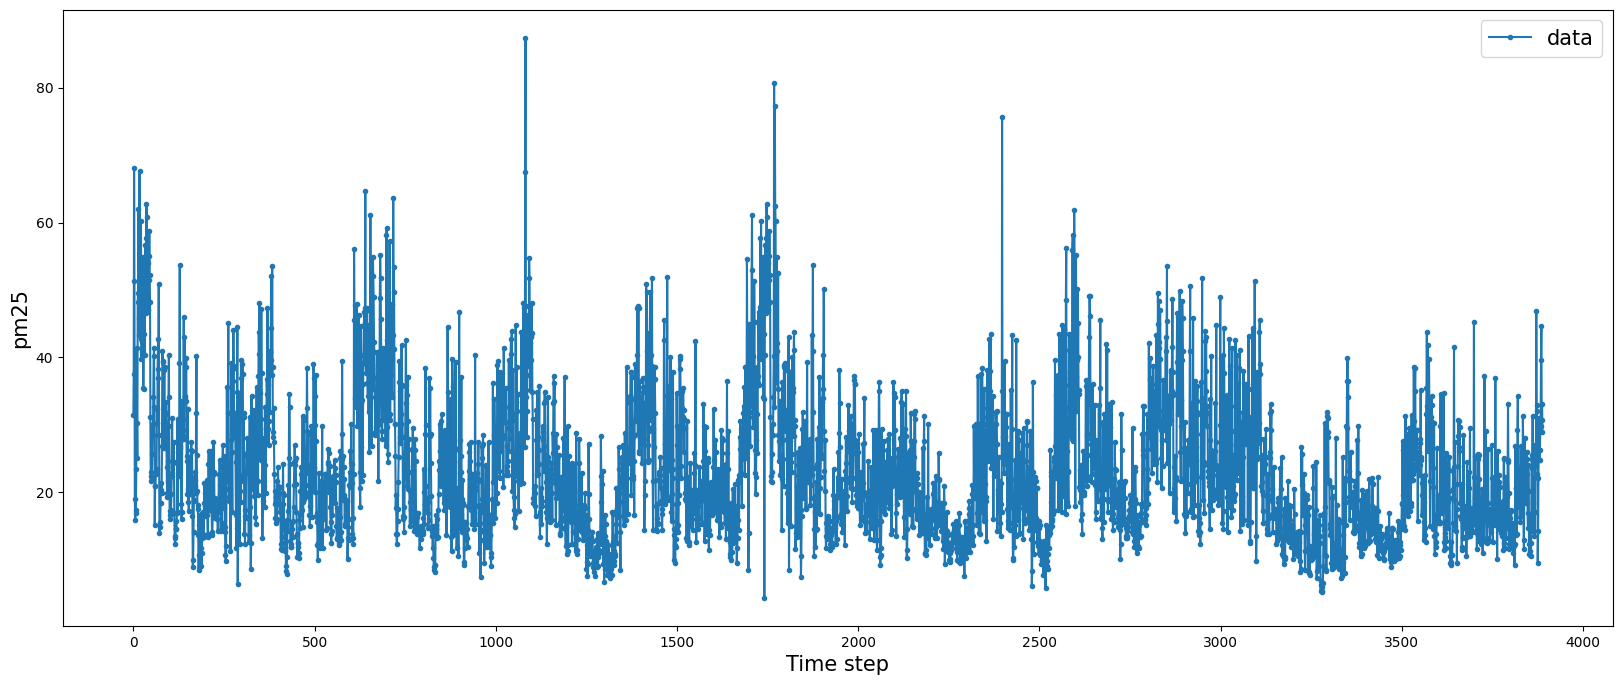

In [33]:
plot_1_data(data=y_aod, datalabel="data", xlabel="Time step", ylabel="pm25")

### Data normalization

In [34]:
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,tmp,hpbl,aod,wspd,rh,pm25_3km
0,0.326794,0.466551,0.0,0.116512,0.471552,0.949821,0.344052,0.00000,0.182582,0.0,0.037975,1.000000,0.0,0.526821,0.342735,0.300502,0.226353,0.170694,0.468797,0.325028
1,0.326794,0.466551,0.0,0.116512,0.471552,0.949821,0.344052,0.00000,0.182582,0.0,0.037975,1.000000,0.0,0.526821,0.303640,0.211553,0.357986,0.110646,0.543165,0.511466
2,0.326794,0.466551,0.0,0.116512,0.471552,0.949821,0.344052,0.00000,0.182582,0.0,0.037975,1.000000,0.0,0.526821,0.415649,0.233097,0.464180,0.029033,0.639575,0.361632
3,0.326794,0.466551,0.0,0.116512,0.471552,0.949821,0.344052,0.00000,0.182582,0.0,0.037975,1.000000,0.0,0.526821,0.450008,0.306153,0.189613,0.068546,0.754117,0.383903
4,0.326794,0.466551,0.0,0.116512,0.471552,0.949821,0.344052,0.00000,0.182582,0.0,0.037975,1.000000,0.0,0.526821,0.365600,0.200556,0.226353,0.191147,0.976269,0.179162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,0.306899,0.237227,1.0,0.857395,0.785926,0.323578,0.075528,0.62963,0.720601,0.0,0.170886,0.375453,0.0,0.085003,0.255396,0.302546,0.172417,0.123912,0.555246,0.319729
3885,0.306899,0.237227,1.0,0.857395,0.785926,0.323578,0.075528,0.62963,0.720601,0.0,0.170886,0.375453,0.0,0.085003,0.395124,0.446013,0.172417,0.163384,0.368885,0.269002
3886,0.306899,0.237227,1.0,0.857395,0.785926,0.323578,0.075528,0.62963,0.720601,0.0,0.170886,0.375453,0.0,0.085003,0.394867,0.584396,0.061473,0.233647,0.403392,0.253703
3887,0.306899,0.237227,1.0,0.857395,0.785926,0.323578,0.075528,0.62963,0.720601,0.0,0.170886,0.375453,0.0,0.085003,0.324368,0.473268,0.172417,0.376650,0.354270,0.158924


In [35]:
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

,pm25
0,0.325673
1,0.398696
2,0.767302
3,0.564825
4,0.175435
...,...
3884,0.425193
3885,0.485609
3886,0.317649
3887,0.346136


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25_3km as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [36]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [37]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

15 16 17 18 19 

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [38]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
# Apply Seq2seq
    lstms2s = LSTMSeq2SeqReduction(X_aod_scaled,
                               test_percentage=0.2,
                               latent_dim=n,
                               n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                               epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                               verbose=0,
                               model_name=f"aod_lstms2s_dim_reduction_{n}_features")
    X_aod_scaled_lstm_s2s_encoded = lstms2s.execute()

    lstms2s.get_model_info()
    lstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_lstm_s2s_encoded
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_lstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 100)    │     48,400 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_6[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 15)        │        765 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 15)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 50)     │     13,200 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 20)     │      2,020 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,957 (1.77 MB)

 Trainable params: 154,985 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,972 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,365 (310.02 KB)

 Trainable params: 79,365 (310.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_12[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │        816 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 16)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_4[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 7, 20)     │      2,020 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,710 (1.78 MB)

 Trainable params: 155,236 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,474 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,416 (310.22 KB)

 Trainable params: 79,416 (310.22 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_18[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 17)        │        867 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 17)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_6[… │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_19[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 20)     │      2,020 │ lstm_21[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,463 (1.78 MB)

 Trainable params: 155,487 (607.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,976 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,467 (310.42 KB)

 Trainable params: 79,467 (310.42 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_24[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 18)        │        918 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 18)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_8[… │
│                     │                   │            │ lstm_25[0][1],    │
│                     │                   │            │ lstm_25[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 7, 20)     │      2,020 │ lstm_27[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,216 (1.78 MB)

 Trainable params: 155,738 (608.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,478 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,518 (310.62 KB)

 Trainable params: 79,518 (310.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_30[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 19)        │        969 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 19)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_10… │
│                     │                   │            │ lstm_31[0][1],    │
│                     │                   │            │ lstm_31[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 7, 20)     │      2,020 │ lstm_33[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,969 (1.79 MB)

 Trainable params: 155,989 (609.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,980 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,569 (310.82 KB)

 Trainable params: 79,569 (310.82 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 4.261778697217206
N = 16 - MAE = 5.077555540060438
N = 17 - MAE = 5.3361293917161445
N = 18 - MAE = 7.326196906403777
N = 19 - MAE = 5.607926731246996


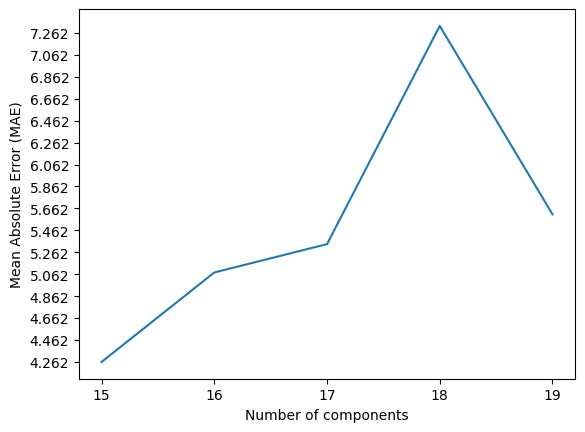

In [39]:
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


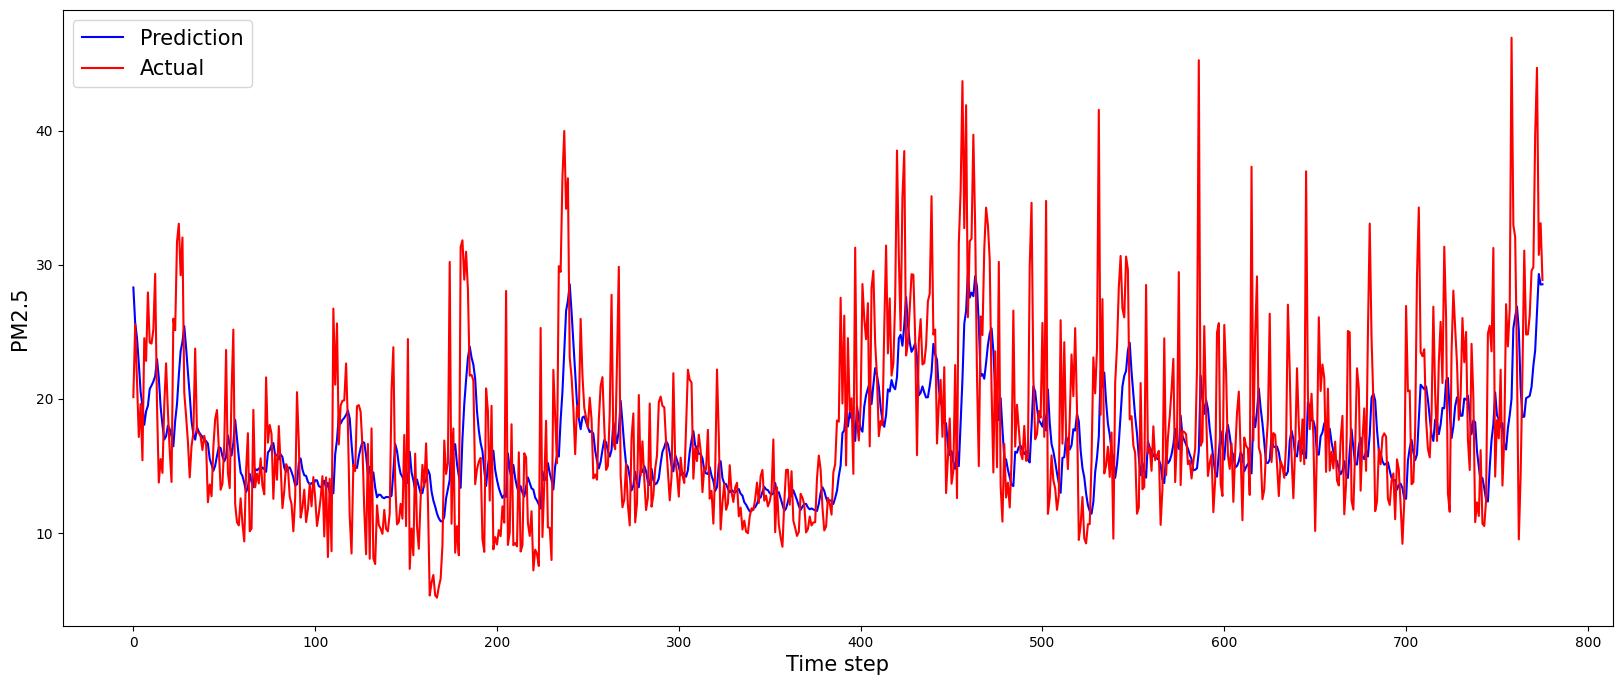

In [40]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

In [41]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

,dim_reduction_method,dim_after_reduction,prediction,mae
0,LSTM-Seq2Seq,15,LSTM,4.261779


### Prediction + GRU-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features")
    X_aod_scaled_gru_s2s_encoded = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_gru_s2s_encoded, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_grus2s_dim_reduction_{n}_features",
                               verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_gru_s2s_encoded
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.1))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
          data2=inv_y_test,
          datalabel1="Prediction",
          datalabel2="Actual",
          xlabel="Time step",
          ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_scaled,
                                       test_percentage=0.2,
                                       latent_dim=n,
                                       n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                       epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                       verbose=0)

    X_aod_scaled_cnnlstm_s2s_encoded = cnnlstms2s.execute()

    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_cnnlstm_s2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstm_s2s_encoded
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["CNN-LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board